In [1]:
%matplotlib inline
import torch
import pyro
import pyro.infer
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

from torch.autograd import Variable

torch.manual_seed(101)

# Introduction

(This tutorial is largely adapted from the disease example in [Chapter 4 of ProbMods](http://probmods.org/chapters/04-patterns-of-inference.html))

Consider the following generative model:

In [2]:
def disease():
    # smoking: some patients smoke cigarettes,
    # which increases their risk of lung disease
    smokes = pyro.sample("smokes", dist.bernoulli, Variable(torch.Tensor([0.2])))
    
    # first latent cause of symptoms: lung disease
    # lung disease has a small probability of arising from exogenous variables
    lung_disease_prior = pyro.sample("lung_disease_prior", dist.bernoulli, Variable(torch.Tensor([0.001])))
    lung_disease = (lung_disease_prior == 1.0).all()
    if (smokes == 1.0).all():
        # smoking dramatically increases the risk of lung disease.
        # we capture this increase with a second risk factor
        # that depends on smokes
        lung_disease_smokes = pyro.sample("lung_disease_smokes", dist.bernoulli, Variable(torch.Tensor([0.1])))
        # finally, we combine risk factors to determine if the patient has lung disease
        lung_disease = lung_disease or (lung_disease_smokes == 1.0).all()
    
    # second latent cause of symptoms: cold
    # unlike lung disease, colds do not have any latent causes in our disease model
    # and arise entirely at random
    cold = pyro.sample("cold", dist.bernoulli, Variable(torch.Tensor([0.02])))
    
    # observable symptoms:
    # all symptoms may arise infrequently due to other external causes
    # first symptom: coughing
    # coughing is a potential symptom of both cold and lung disease
    cough_prior = pyro.sample("cough_prior", dist.bernoulli, Variable(torch.Tensor([0.01])))
    cough = (cough_prior == 1.0).all()
    if (cold == 1.0).all():
        # having a cold greatly increases the probability of coughing
        cough_cold = pyro.sample("cough_cold", dist.bernoulli, Variable(torch.Tensor([0.5])))
        cough = cough or (cough_cold == 1.0).all()
    if lung_disease:
        # having lung disease also greatly increases the probability of coughing
        cough_lung = pyro.sample("cough_lung", dist.bernoulli, Variable(torch.Tensor([0.5])))
        cough = cough or (cough_lung == 1.0).all()
        
    # second symptom: fever
    # fever is only a potential symptom of cold
    fever_prior = pyro.sample("fever_prior", dist.bernoulli, Variable(torch.Tensor([0.01])))
    fever = (fever_prior == 1.0).all()
    if (cold == 1.0).all():
        # having a cold increases the probability of fever
        fever_cold = pyro.sample("fever_cold", dist.bernoulli, Variable(torch.Tensor([0.3])))
        fever = fever or (fever_cold == 1.0).all()
        
    # third symptom: chest pain
    # chest pain is only a potential symptom of lung disease
    chest_pain_prior = pyro.sample("chest_pain_prior", dist.bernoulli, Variable(torch.Tensor([0.01])))
    chest_pain = (chest_pain_prior == 1.0).all()
    if lung_disease:
        # having lung disease increases the probability of chest pain,
        # but it is still much less likely than coughing
        chest_pain_lung = pyro.sample("chest_pain_lung", dist.bernoulli, Variable(torch.Tensor([0.2])))
        chest_pain = chest_pain or (chest_pain_lung == 1.0).all()

    # here we add some meaningless sample statements
    # that allow us to constrain the observable symptoms.
    # Note that this is a generally useful technique
    pd = lambda b: Variable(torch.Tensor([1])) if b else Variable(torch.Tensor([0]))
    pyro.sample("lung_disease", dist.bernoulli, pd(lung_disease))
    pyro.sample("cough", dist.bernoulli, pd(cough))
    pyro.sample("fever", dist.bernoulli, pd(fever))
    pyro.sample("chest_pain", dist.bernoulli, pd(chest_pain))
    
    # return the symptoms
    return {
        "cough": cough,
        "fever": fever,
        "chest_pain": chest_pain,
    }

# Observation and Intervention

In addition to `pyro.condition`, which was introduced in the [inference tutorial](https://pyro.ai/examples/intro_part_ii.html), Pyro provides `pyro.do`, an implementation of Pearl's `do`-operator for direct intervention in probabilistic models.  `pyro.do` has the same interface as `pyro.condition`:

In [3]:
intervened_cold = pyro.do(disease, data={"cold": Variable(torch.ones(1))})
intervened_no_cold = pyro.do(disease, data={"cold": Variable(torch.zeros(1))})

Intervention in a Pyro model is equivalent to editing the model's code and replacing a particular `sample` statement with a hard-coded value.  For example, 
```python
intervened_cold = pyro.do(disease, data={"cold": Variable(torch.ones(1))})
```
is equivalent to replacing the line in `disease`
```python
cold = pyro.sample("cold", dist.bernoulli, Variable(torch.Tensor([0.02])))
```
with the line
```python
cold = Variable(torch.ones(1))
```
Similarly, `intervened_no_cold` is equivalent to replacing the above sample statement with
```python
cold = Variable(torch.zeros(1))
```

What if we gave patients a cold?

(0, 1)

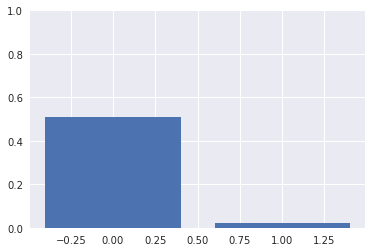

In [4]:
marginal_intervened_cold = pyro.infer.Marginal(pyro.infer.Search(intervened_cold), sites=["cough"])
marginal_intervened_no_cold = pyro.infer.Marginal(pyro.infer.Search(intervened_no_cold), sites=["cough"])

p_cough_do_cold = torch.exp(marginal_intervened_cold.log_pdf({"cough": Variable(torch.ones(1))}))
p_cough_do_no_cold = torch.exp(marginal_intervened_no_cold.log_pdf({"cough": Variable(torch.ones(1))}))

plt.bar(np.arange(0, 2), (p_cough_do_cold.data[0], p_cough_do_no_cold.data[0]))
plt.ylim(0, 1)

Now suppose instead that we give all patients a cough medicine.  We can see that treating symptoms does not treat the underlying causes of coughing: the probability of having a cold is unaffected by the intervention.

(0, 1)

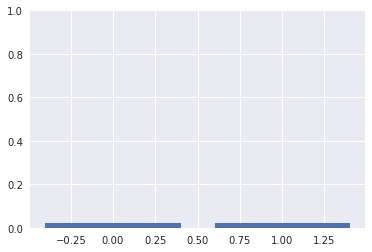

In [11]:
# administering cough medicine
intervened_no_cough = pyro.do(disease, data={"cough": Variable(torch.zeros(1))})

# does treating the symptoms treat the underlying cause?
marginal_cold = pyro.infer.Marginal(pyro.infer.Search(disease), sites=["cold"])
marginal_cold_do_no_cough = pyro.infer.Marginal(pyro.infer.Search(intervened_no_cough), sites=["cold"])

p_cold = torch.exp(marginal_cold.log_pdf({"cold": Variable(torch.ones(1))}))
p_cold_do_no_cough = torch.exp(marginal_cold_do_no_cough.log_pdf({"cold": Variable(torch.ones(1))}))

plt.bar(np.arange(0, 2), (p_cold.data[0], p_cold_do_no_cough.data[0]))
plt.ylim(0, 1)

Finally, we can try combining intervention and conditioning.  Suppose we want to estimate whether smoking causes lung disease.  We can estimate the observational distribution `p(lung_disease | cough=True, fever=False)`.  To answer this question clearly, we could intervene and perform a randomized experiment: splitting people with these symptoms into smokers and non-smokers.

In [5]:
symptoms = {"cough": Variable(torch.ones(1)), "fever": Variable(torch.zeros(1))}
outcome = {"lung_disease": Variable(torch.ones(1))}

# observational distribution
obs_disease = pyro.condition(disease, data=symptoms)

# interventional distributions
nonsmoker_obs_disease = pyro.do(obs_disease, data={"smokes": Variable(torch.zeros(1))})
smoker_obs_disease = pyro.do(obs_disease, data={"smokes": Variable(torch.ones(1))})

(0, 1)

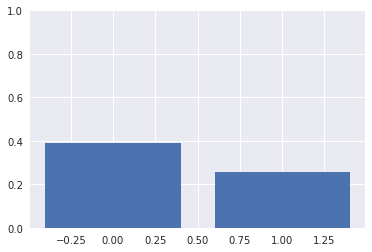

In [6]:
# marginals
marginal1_obs = pyro.infer.Marginal(pyro.infer.Search(obs_disease), sites=["lung_disease"])
marginal2_obs = pyro.infer.Marginal(pyro.infer.Search(obs_disease), sites=["lung_disease", "cold"])

# probabilities
p_lung_given_obs = torch.exp(marginal1_obs.log_pdf(outcome))
p_cold_not_lung_given_obs = torch.exp(marginal2_obs.log_pdf({
    "lung_disease": Variable(torch.zeros(1)),
    "cold": Variable(torch.ones(1))
}))

plt.bar(np.arange(0, 2), (p_lung_given_obs.data[0], p_cold_not_lung_given_obs.data[0]))
plt.ylim(0, 1)

(0, 1)

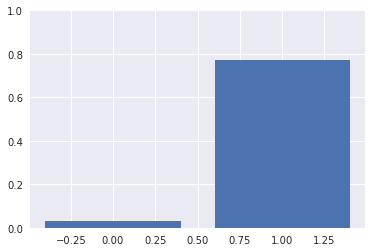

In [7]:
# marginals of intervention distributions
marginal_nonsmoker_obs = pyro.infer.Marginal(
    pyro.infer.Search(nonsmoker_obs_disease), sites=["lung_disease"])
marginal_smoker_obs = pyro.infer.Marginal(
    pyro.infer.Search(smoker_obs_disease), sites=["lung_disease"])

# probabilities
p_lung_given_obs_do_nonsmoker = torch.exp(marginal_nonsmoker_obs.log_pdf(outcome))
p_lung_given_obs_do_smoker = torch.exp(marginal_smoker_obs.log_pdf(outcome))

plt.bar(np.arange(0, 2), (p_lung_given_obs_do_nonsmoker.data[0], p_lung_given_obs_do_smoker.data[0]))
plt.ylim(0, 1)